## Add Bullpen to Model
- In the last notebook we augmented our dataframe to include various features based on the starting pitcher's performance
- Now we will add these features in to see how much improvement we get to our model.

In [1]:
# Uncomment if you need to install any of the following packages
# !pip install lightgbm
# !pip install ml_insights --upgrade
# !pip install structureboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [3]:
df=pd.read_csv('df_bp7.csv')

/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (13,14,15,19,85,87,159,206) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Begin Modeling

In [4]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1980) & (df.season<=2018) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2019) & (df.season<=2020)]
df_test = df[df.season>=2021]


In [5]:
df.shape

(96213, 619)

In [6]:
hv_mean = df_train.home_victory.mean()

In [7]:
np.array(df.columns)

array(['date', 'dblheader_code', 'day_of_week', 'team_v', 'league_v',
       'game_no_v', 'team_h', 'league_h', 'game_no_h', 'runs_v', 'runs_h',
       'outs_total', 'day_night', 'completion_info', 'forfeit_info',
       'protest_info', 'ballpark_id', 'attendance', 'game_minutes',
       'linescore_v', 'linescore_h', 'AB_v', 'H_v', '2B_v', '3B_v',
       'HR_v', 'RBI_v', 'SH_v', 'SF_v', 'HBP_v', 'BB_v', 'IBB_v', 'SO_v',
       'SB_v', 'CS_v', 'GIDP_v', 'CI_v', 'LOB_v', 'P_num_v', 'ERind_v',
       'ERteam_v', 'WP_v', 'balk_v', 'PO_v', 'ASST_v', 'ERR_v', 'PB_v',
       'DP_v', 'TP_v', 'AB_h', 'H_h', '2B_h', '3B_h', 'HR_h', 'RBI_h',
       'SH_h', 'SF_h', 'HBP_h', 'BB_h', 'IBB_h', 'SO_h', 'SB_h', 'CS_h',
       'GIDP_h', 'CI_h', 'LOB_h', 'P_num_h', 'ERind_h', 'ERteam_h',
       'WP_h', 'balk_h', 'PO_h', 'ASST_h', 'ERR_h', 'PB_h', 'DP_h',
       'TP_h', 'ump_HB_id', 'ump_HB_name', 'ump_1B_id', 'ump_1B_name',
       'ump_2B_id', 'ump_2B_name', 'ump_3B_id', 'ump_3B_name',
       'ump_LF_id'

## Let's add in some basic bullpen features

In [8]:
target = 'home_victory'

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()



In [9]:
def try_features(feat_set, max_depth=2):
    target = 'home_victory'
    X_train = df_train.loc[:,feat_set]
    X_valid = df_valid.loc[:,feat_set]
    X_test = df_test.loc[:,feat_set]



    lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=max_depth)
    lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50)])
    
    preds_lgbm_test = lgbm1.predict_proba(X_test)[:,1]
    ll_test = log_loss(y_test, preds_lgbm_test)

    print(f'\nVegas probs: {log_loss(y_test,df_test.implied_prob_h_mid)} on test')
    print(f'model probs: {ll_test} on test')

    print(f'\nDifference: {ll_test - log_loss(y_test,df_test.implied_prob_h_mid)} on test')

    sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
    sv_lgbm = pd.DataFrame(sv_lgbm)
    sv_lgbm.columns = list(X_test.columns)+['Intercept']
    sv_vec = sv_lgbm.abs().mean().sort_values(ascending=False)
    print('\nAvg Shap Vals')
    
    print(sv_vec)
    out_dict={}
    out_dict['ll_test'] = ll_test
    out_dict['model'] = lgbm1
    out_dict['shap_val_avgs'] = sv_vec
    out_dict['preds_test'] = preds_lgbm_test
    return(out_dict)

In [10]:
features1 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
]



In [11]:
d1 = try_features(features1)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[432]	valid_0's binary_logloss: 0.675749

Vegas probs: 0.6675629431340582 on test
model probs: 0.6745326542156883 on test

Difference: 0.006969711081630137 on test

Avg Shap Vals
Intercept               0.158975
Strt_SO_perc_10_v       0.081522
Strt_SO_perc_10_h       0.075016
OBP_162_v               0.064723
Strt_WHIP_35_v          0.057966
OBP_162_h               0.057439
Strt_WHIP_35_h          0.052729
SLG_162_h               0.041339
Strt_TB_BB_perc_35_h    0.039812
SLG_162_v               0.034628
Strt_TB_BB_perc_35_v    0.029043
Strt_H_BB_perc_35_h     0.021468
Strt_H_BB_perc_35_v     0.021165
dtype: float64


In [12]:
features2 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
]


In [13]:
d2 = try_features(features2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[561]	valid_0's binary_logloss: 0.674106

Vegas probs: 0.6675629431340582 on test
model probs: 0.67242273071281 on test

Difference: 0.0048597875787518285 on test

Avg Shap Vals
Intercept               0.159234
Strt_SO_perc_10_h       0.082147
Strt_SO_perc_10_v       0.081890
OBP_162_v               0.063890
Strt_WHIP_35_v          0.054428
Strt_WHIP_35_h          0.053719
OBP_162_h               0.052719
SLG_162_h               0.042107
SLG_162_v               0.038715
Strt_TB_BB_perc_35_h    0.037582
Strt_TB_BB_perc_35_v    0.029401
Bpen_SO_perc_35_v       0.028163
Bpen_H_BB_perc_35_h     0.024404
Bpen_H_BB_perc_35_v     0.022242
Strt_H_BB_perc_35_v     0.020792
Bpen_TB_BB_perc_35_v    0.018768
Strt_H_BB_perc_35_h     0.017186
Bpen_SO_perc_35_h       0.014536
Bpen_TB_BB_perc_35_h    0.011636
Bpen_WHIP_35_h          0.004387
Bpen_WHIP_35_v          0.003951
dtype: float64


In [14]:
features3 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
]


In [15]:
d3 = try_features(features3, max_depth=2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[628]	valid_0's binary_logloss: 0.67291

Vegas probs: 0.6675629431340582 on test
model probs: 0.6714216560589157 on test

Difference: 0.0038587129248575103 on test

Avg Shap Vals
Intercept               0.159380
Strt_SO_perc_10_h       0.081908
Strt_SO_perc_10_v       0.080985
OBP_162_v               0.063181
Strt_WHIP_35_v          0.053390
Strt_WHIP_35_h          0.050850
OBP_162_h               0.049462
SLG_162_h               0.043181
Strt_TB_BB_perc_35_h    0.038065
SLG_162_v               0.036927
Strt_TB_BB_perc_35_v    0.028336
Bpen_SO_perc_75_v       0.026247
Bpen_TB_BB_perc_75_h    0.021284
Strt_H_BB_perc_35_v     0.020384
Strt_H_BB_perc_35_h     0.019739
Bpen_H_BB_perc_75_h     0.018050
Bpen_H_BB_perc_35_v     0.015877
Bpen_TB_BB_perc_75_v    0.015706
Bpen_H_BB_perc_35_h     0.015220
Bpen_TB_BB_perc_10_v    0.012679
Bpen_H_BB_perc_75_v     0.010479
Bpen_SO_perc_35_v       0.009404

In [16]:
features4 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_75_h','Strt_WHIP_75_v',
            'Strt_TB_BB_perc_75_h', 'Strt_TB_BB_perc_75_v',
            'Strt_H_BB_perc_75_h', 'Strt_H_BB_perc_75_v',
            'Strt_SO_perc_75_h', 'Strt_SO_perc_75_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_WHIP_10_h','Strt_WHIP_10_v',
            'Strt_TB_BB_perc_10_h', 'Strt_TB_BB_perc_10_v',
            'Strt_H_BB_perc_10_h', 'Strt_H_BB_perc_10_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
]


In [17]:
d4 = try_features(features4)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[735]	valid_0's binary_logloss: 0.672626

Vegas probs: 0.6675629431340582 on test
model probs: 0.6719017733525425 on test

Difference: 0.0043388302184843575 on test

Avg Shap Vals
Intercept               0.159707
OBP_162_v               0.063302
Strt_SO_perc_10_h       0.055539
OBP_162_h               0.048788
Strt_SO_perc_10_v       0.048730
Strt_H_BB_perc_75_h     0.043753
SLG_162_h               0.041496
Strt_SO_perc_35_v       0.040494
Strt_WHIP_75_v          0.039426
SLG_162_v               0.036805
Strt_SO_perc_35_h       0.028736
Bpen_SO_perc_75_v       0.027860
Strt_WHIP_35_h          0.022494
Strt_TB_BB_perc_35_h    0.021701
Bpen_H_BB_perc_35_h     0.021503
Bpen_TB_BB_perc_75_h    0.020310
Bpen_H_BB_perc_75_h     0.018958
Strt_WHIP_35_v          0.018719
Strt_TB_BB_perc_35_v    0.017691
Strt_TB_BB_perc_10_h    0.017524
Bpen_H_BB_perc_35_v     0.017113
Strt_TB_BB_perc_75_h    0.01498

In [18]:
features5 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
             'ERR_162_h', 'ERR_162_v',
             'SB_162_h', 'SB_162_v',
             'CS_162_h', 'CS_162_v',
             
             
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
]


In [19]:
d5 = try_features(features5)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[640]	valid_0's binary_logloss: 0.673276

Vegas probs: 0.6675629431340582 on test
model probs: 0.6717831567428961 on test

Difference: 0.004220213608837953 on test

Avg Shap Vals
Intercept               0.159339
Strt_SO_perc_10_v       0.081499
Strt_SO_perc_10_h       0.080460
OBP_162_v               0.058813
Strt_WHIP_35_v          0.052385
Strt_WHIP_35_h          0.051278
OBP_162_h               0.048423
SLG_162_h               0.041351
Strt_TB_BB_perc_35_h    0.039360
SLG_162_v               0.036431
Strt_TB_BB_perc_35_v    0.028537
Bpen_SO_perc_75_v       0.025448
Bpen_TB_BB_perc_75_h    0.022011
Strt_H_BB_perc_35_v     0.020487
Strt_H_BB_perc_35_h     0.017059
Bpen_H_BB_perc_35_v     0.016336
Bpen_H_BB_perc_75_h     0.016125
Bpen_TB_BB_perc_75_v    0.015249
Bpen_H_BB_perc_35_h     0.014152
SB_162_v                0.012051
Bpen_TB_BB_perc_10_v    0.010117
Bpen_H_BB_perc_75_v     0.009918

In [20]:
rd = mli.get_range_dict(df_train)
plot_pts = df_test.loc[:,features5].sample(1, random_state=42)

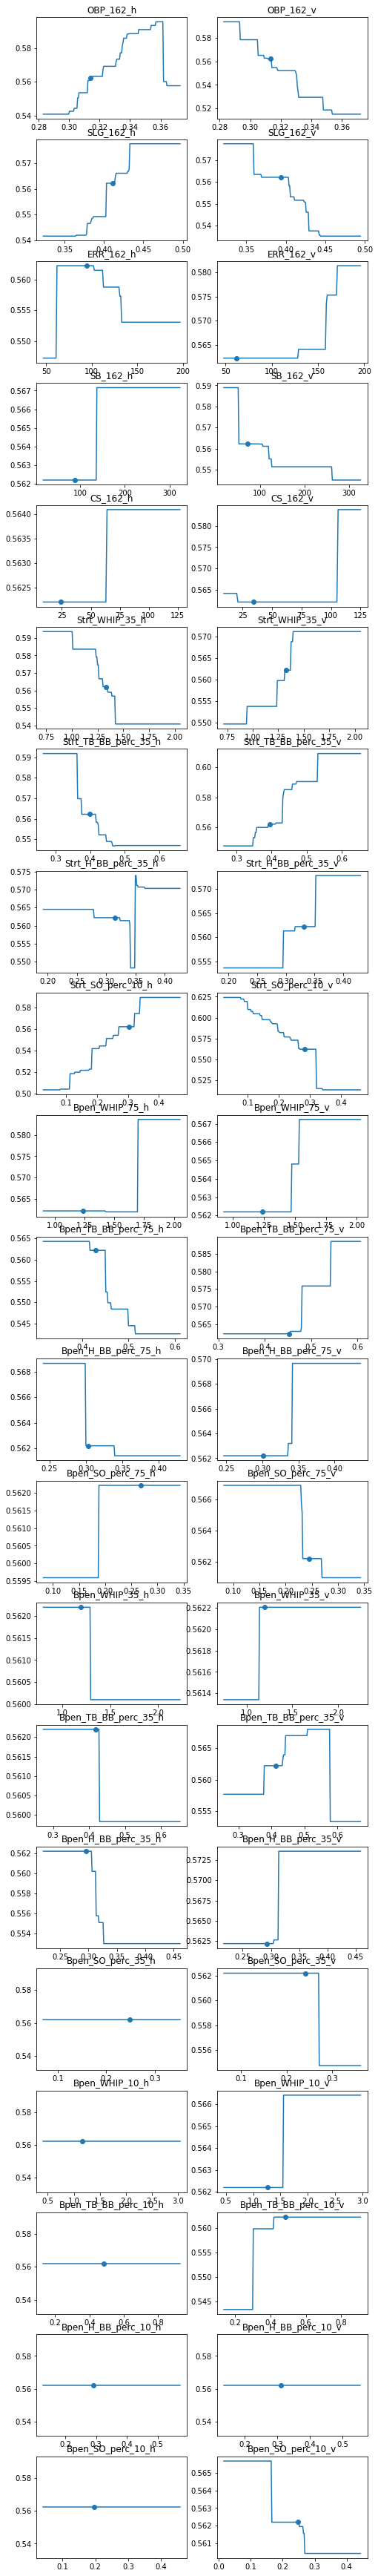

In [21]:
mli.ice_plot(d5['model'], plot_pts, features5, rd, plots_per_row=2)

In [22]:
df['SBadj_162_h'] = df['SB_162_h'] - 3*df['CS_162_h']
df['SBadj_162_v'] = df['SB_162_v'] - 3*df['CS_162_v']

In [23]:
df_train = df[(df.season>1980) & (df.season<=2018) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2019) & (df.season<=2020)]
df_test = df[df.season>=2021]
df_test_val = df[df.season>=2019]

In [24]:
features6  = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
             'ERR_162_h', 'ERR_162_v',
             # 'SB_162_h', 'SB_162_v',
             # 'CS_162_h', 'CS_162_v',
             'SBadj_162_h','SBadj_162_v',
             
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
              
]

In [25]:
d6 = try_features(features6)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[647]	valid_0's binary_logloss: 0.673242

Vegas probs: 0.6675629431340582 on test
model probs: 0.6718162089847997 on test

Difference: 0.004253265850741483 on test

Avg Shap Vals
Intercept               0.159346
Strt_SO_perc_10_v       0.080905
Strt_SO_perc_10_h       0.080209
OBP_162_v               0.060246
Strt_WHIP_35_v          0.051972
Strt_WHIP_35_h          0.051547
OBP_162_h               0.047230
SLG_162_h               0.041814
Strt_TB_BB_perc_35_h    0.037566
SLG_162_v               0.034788
Strt_TB_BB_perc_35_v    0.028543
Bpen_SO_perc_75_v       0.026463
Bpen_TB_BB_perc_75_h    0.022138
Strt_H_BB_perc_35_v     0.020611
Strt_H_BB_perc_35_h     0.018056
Bpen_H_BB_perc_75_h     0.016356
Bpen_H_BB_perc_35_v     0.016342
Bpen_TB_BB_perc_75_v    0.015420
Bpen_H_BB_perc_35_h     0.013634
SBadj_162_h             0.011652
Bpen_TB_BB_perc_10_v    0.011291
Bpen_H_BB_perc_75_v     0.010517

In [26]:
rd = mli.get_range_dict(df_train)
plot_pts = df_test.loc[:,features6].sample(3, random_state=42)

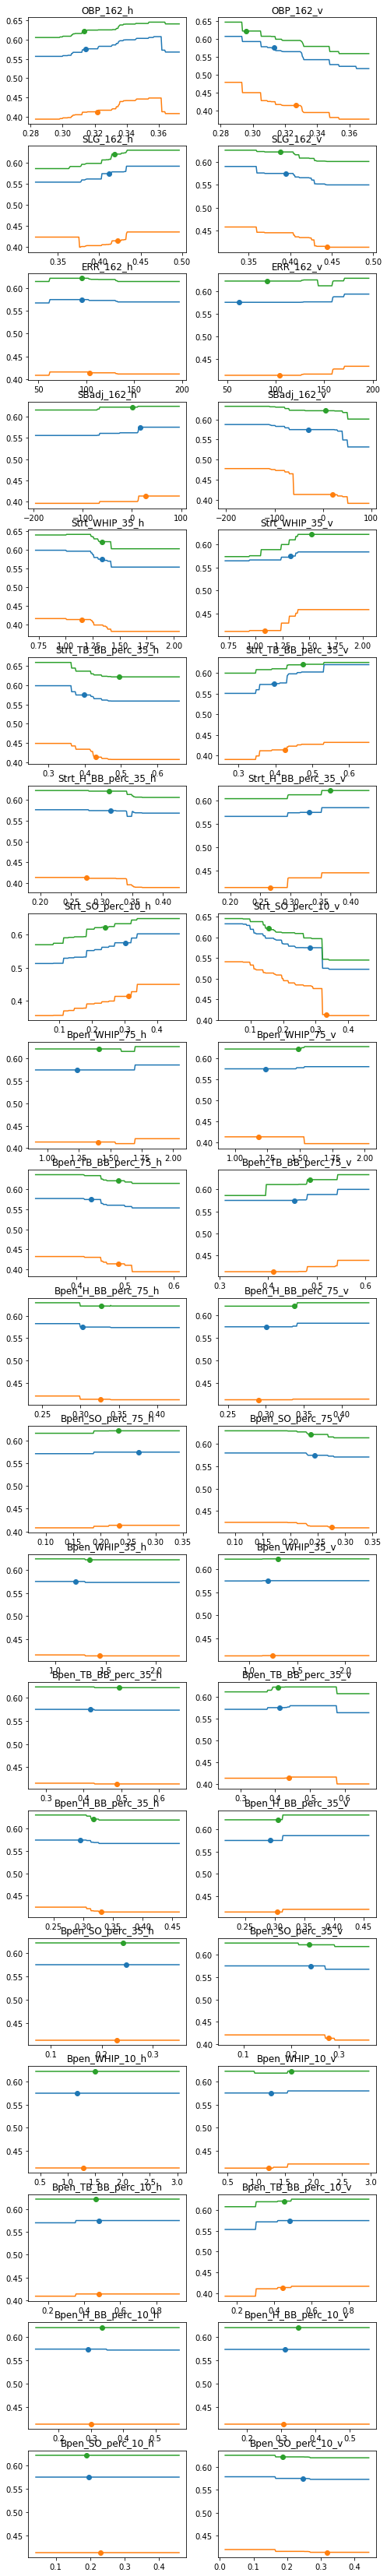

In [27]:
mli.ice_plot(d6['model'], plot_pts, features6, rd, plots_per_row=2)

## Let's analyze model 3

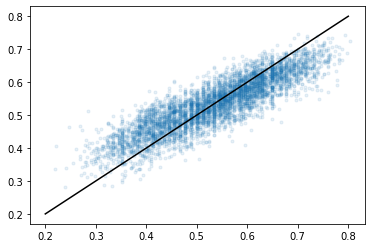

In [28]:
plt.scatter(df_test.implied_prob_h_mid, d3['preds_test'], marker='.', alpha=.1)
plt.plot([.2,.8],[.2,.8], color='k')

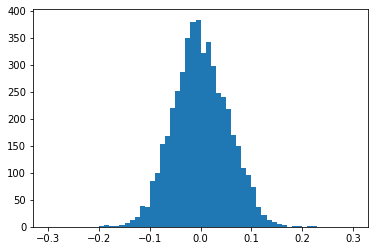

In [29]:
test_disc = d3['preds_test'] - df_test.implied_prob_h_mid
plt.hist(test_disc, bins=np.linspace(-.3,.3,61));

In [30]:
## let's compare performance on the cases with a large discrepancy
mask = (np.abs(test_disc))>.1
log_loss(y_test[mask], d3['preds_test'][mask]), log_loss(y_test[mask], df_test.implied_prob_h_mid[mask])

(0.6763921425249306, 0.6479924845754601)

In [31]:
log_loss(y_test[~mask], d3['preds_test'][~mask]), log_loss(y_test[~mask], df_test.implied_prob_h_mid[~mask])

(0.6711056891419618, 0.668807009986753)

# Conclusions
- ## Still about 40 bps away from Vegas probabilities (down from ~70)
- ## When our model and Vegas "disagree", Vegas is generally right!
- ## We are running out of "big wins"
    - ### Features based on actual starting lineup
    - ### Fielding
    - ### Lefty vs Righty analysis

# Next Steps
- ## Get individual batter data
- ## Make features based on the actual lineup
- ## Analyze runs scored (over/under)
- ## Perhaps the model for runs scored will help with the moneyline model